In [1]:
import numpy as np
import pandas as pd 
import os
import shutil
from pathlib import Path
import nibabel as nib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision
import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import pydicom
import tarfile
import cv2

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Preprocessing

In [2]:
data_path = "/kaggle/input/rsnacardiacdetectionlabels/rsna_heart_detection.csv"
data = pd.read_csv(data_path)
data.head()

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


### Copy Images

In [3]:
source_dir = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"
destination_dir = "./data"

sums, sums_squared = 0, 0

files = [f"{name}.dcm" for name in data['name']]

for i, file in enumerate(files):
    train_or_val = "train" if (i < 400) else "val"
    dest_dir = os.path.join(destination_dir, train_or_val)

    # Creating the destination directory if it doesn't exist
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    source_path = os.path.join(source_dir, file)
    dest_path = os.path.join(dest_dir, file.split('.')[0])

    dcm = pydicom.read_file(source_path)
    dcm_arr = dcm.pixel_array
    dcm_arr = (cv2.resize(dcm_arr, (224, 224))/255).astype(np.float32)

    np.save(dest_path, dcm_arr)

    normalizer = 224 * 224
    if train_or_val == "train":
        sums += np.sum(dcm_arr) / normalizer
        sums_squared += np.sum(dcm_arr**2) / normalizer


In [4]:
train_path = Path('./data/train')
val_path = Path('./data/val')
save_path = Path('./preprocessed')

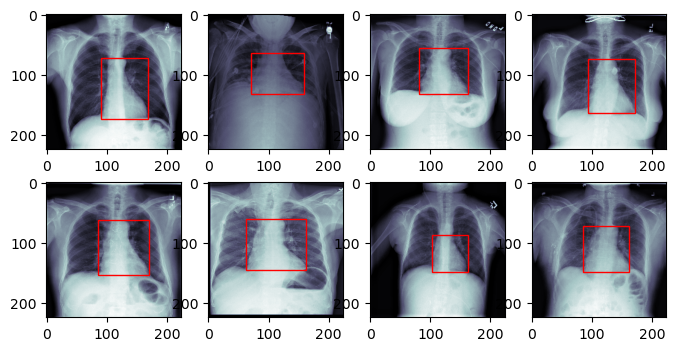

In [5]:
n_rows = 2
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 4))
c = 0
for i in range(n_rows):
    for j in range(n_cols):
        pt_data = data.iloc[c]
        pt_id = pt_data['name']
        img_path = train_path/pt_id
        img_path = img_path.with_suffix('.npy')
        
        img_arr = np.load(img_path)
        
        x = pt_data['x0']
        y = pt_data['y0']
        width = pt_data['w']
        height = pt_data['h']
        
        axes[i][j].imshow(img_arr, cmap='bone')
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        axes[i][j].add_patch(rect)
        c += 1

In [6]:
mean = sums / 400
std = np.sqrt((sums_squared / 400) - mean**2)
mean, std

(0.49431332860674204, 0.2527908571336299)

# Dataset

In [7]:
class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_labels_csv, root_path, augs):
        self.labels = pd.read_csv(path_to_labels_csv)
        self.root_path = Path(root_path)
        self.patients = os.listdir(root_path)
        self.augment = augs
        
    def __len__(self):
        return len(self.patients)
    
    def __getitem__(self, idx):
        patient = self.patients[idx]
        data = self.labels[self.labels['name'] == patient.split('.')[0]]
        
        x_min = data['x0'].item()
        y_min = data['y0'].item()
        x_max = x_min + data['w'].item()
        y_max = y_min + data['h'].item()
        bbox = [x_min, y_min, x_max, y_max]
        
        file_path = self.root_path/patient
        img = np.load(file_path).astype(np.float32)
        
        if self.augment:
            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
            random_seed = torch.randint(0, int(1e+5), (1,)).item()
            imgaug.seed(random_seed)
            
            img, aug_bbox = self.augment(image=img, bounding_boxes=bb)
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]
        
        img = (img - 0.494) / 0.252
        img = torch.tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)
        return img, bbox

In [8]:
train_transform = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(scale=(0.8, 1.2), rotate=(-10, 10), translate_px=(-10, 10))
])

In [9]:
train_dataset = CardiacDataset(data_path, train_path, train_transform)
val_dataset = CardiacDataset(data_path, val_path, None)

### Testing Dataset

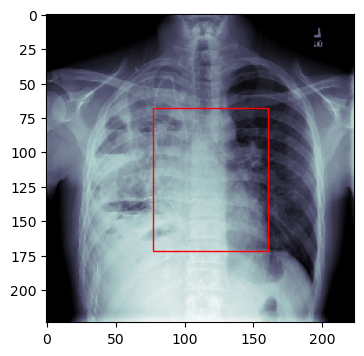

In [10]:
img, bbox = val_dataset[0]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.imshow(img[0], cmap='bone')
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

In [11]:
batch_size = 16
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, num_workers=num_workers, shuffle=False)

# Model

In [12]:
class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18(weights=False)
        self.model.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=64, kernel_size=7,
            stride=2, padding=3, bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()
        
    def forward(self, data):
        return self.model(data)
    
    def training_step(self, batch, batch_idx):
        img, label = batch
        label = label.float()
        pred = self(img)
        loss = self.loss_fn(pred, label)
        
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(img.cpu(), pred.cpu(), label.cpu(), "Train")
            
        return loss
        
        
    def validation_step(self, batch, batch_idx):
        img, label = batch
        label = label.float()
        pred = self(img)
        loss = self.loss_fn(pred, label)
        
        self.log("Val Loss", loss)
        if batch_idx % 10 == 0:
            self.log_images(img.cpu(), pred.cpu(), label.cpu(), "Val")
            
        return loss
    
    def log_images(self, x_ray, pred, label, name):
        results = []
        
        for i in range(4):
            coord_labels = label[i]
            coord_pred = pred[i]
            
            img = ((x_ray[i] * 0.252) + 0.494).numpy()[0]
            
            x0, y0 = coord_labels[0].int().item(), coord_labels[1].int().item()
            x1, y1 = coord_labels[2].int().item(), coord_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            
            x0, y0 = coord_pred[0].int().item(), coord_pred[1].int().item()
            x1, y1 = coord_pred[2].int().item(), coord_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)
            
            results.append(torch.tensor(img).unsqueeze(0))
        
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(name, grid, self.global_step)
        
    def configure_optimizers(self):
        return [self.optimizer]

In [13]:
model = CardiacDetectionModel()
model

CardiacDetectionModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

# Training

In [14]:
checkpoint_callback = ModelCheckpoint(monitor="Val Loss", save_top_k=10, mode="min")

In [15]:
trainer = pl.Trainer(logger=TensorBoardLogger('./logs'), log_every_n_steps=1, callbacks=checkpoint_callback, max_epochs=100)

In [16]:
trainer.fit(model, train_loader, val_loader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Validation

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = model.load_from_checkpoint('./logs/lightning_logs/version_0/checkpoints/epoch=99-step=2500.ckpt')
# model.eval()
model.to(device)

CardiacDetectionModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [18]:
preds = []
labels = []

with torch.no_grad():
    for data, label in val_dataset:
        data = data.to(device).float().unsqueeze(0)
        # removing the batch channel dim
        pred = model(data)[0].cpu()
        preds.append(pred)
        labels.append(label)
        
preds = torch.stack(preds)
labels = torch.stack(labels)

In [19]:
abs(preds - labels).mean(0)

tensor([ 8.2982,  9.2567, 10.6024, 16.4696])

### Visualize predictions

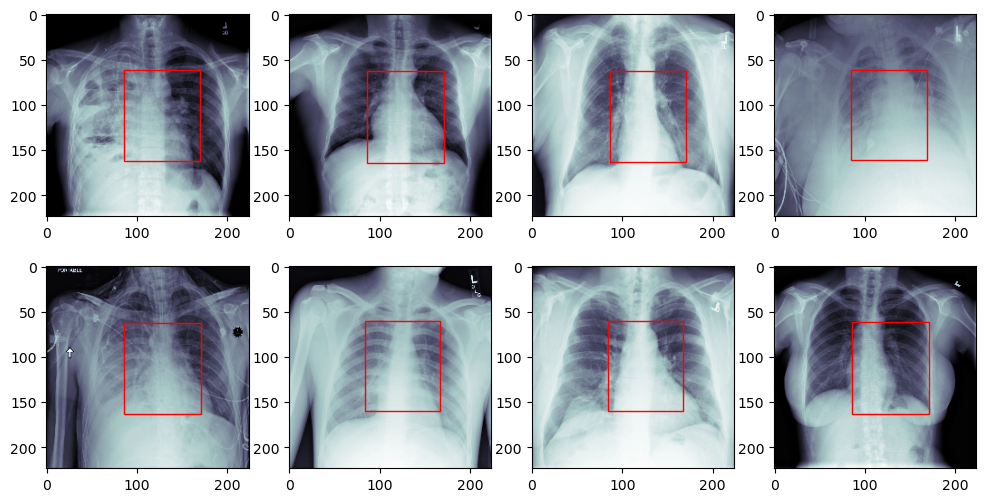

In [20]:
n_rows = 2
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
idx = 0
for i in range(n_rows):
    for j in range(n_cols):
        img, label = val_dataset[idx]
        pred = preds[idx]
        
        axes[i][j].imshow(img[0], cmap='bone')
        heart = patches.Rectangle((pred[0], pred[1]), pred[2]-pred[0], pred[3]-pred[1], edgecolor='r', facecolor='none')
        axes[i][j].add_patch(heart)
        idx += 1